## Importamos las librerias

In [160]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from mlxtend.classifier import StackingCVClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import RandomizedSearchCV,cross_val_score, KFold



# Cargamos los datos

In [101]:
#Cargamos los datos
df = pd.read_csv('data/fraude_tc.csv')

In [102]:
#Separamos los datos en variables y objetivo
X = df.drop(['fraud'], axis=1)
y = df['fraud']

## Separación de los datos

In [103]:
#Separamos en datos de entrenamiento y datos de validacion (para hacer un maquetado rápido del modelo, para mayor rigurosidad, usaremos una validación cruzada)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Transformamos los datos

In [152]:
from sklearn.preprocessing import MinMaxScaler

# Pipeline para el preprocesamiento de los datos, en el EDA se observó que hay sólo columnas numéricas
numerical = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler()) #en el EDA se observó outliers en 3 columnas
])

# Modelo

In [153]:
#Eligimos los mejores clasificadores
random_forest = RandomForestClassifier()
ada_boost = AdaBoostClassifier()
xgb = XGBClassifier()

In [154]:
#Utilizamos StackCVClassifier para combinar los clasificadores y obtener un mejor resultado ()
model = StackingCVClassifier(
    classifiers=[random_forest, ada_boost, xgb],
    meta_classifier=xgb
)

#PipeLine para el modelo general
pipe = Pipeline(steps=[
    ('numerical', numerical),
    ('model', model)
])

In [164]:
""" #Entrenamos el modelo (maquetacion)
pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)
accuracy_score(y_test, pred) """

0.99999

In [161]:
#Entrenamiento del modelo con crossvalidation y KFolds
score = cross_val_score(pipe, X, y, cv=KFold(n_splits=5,shuffle=True, random_state=42), scoring='accuracy')

In [163]:
score

array([0.99999 , 1.      , 0.999995, 0.99999 , 0.99999 ])

In [162]:
# En una maquetación anterior se logró 0.999995( 'mejor' ), con crossvalidation se obtiene un 0.999999
np.abs(score).min()

0.99999

<AxesSubplot:>

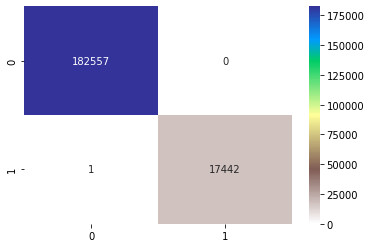

In [157]:
y_pred = pipe.predict(X_test)
matrx = confusion_matrix(y_test, y_pred)
sns.heatmap(matrx, annot=True, fmt='d', cmap='terrain_r')

In [158]:
accuracy_score(y_test, y_pred)

0.999995

In [159]:
y_pred = pd.DataFrame(y_pred, columns=['pred'])
path_pred = './out/pred_test.csv'
y_pred.to_csv(path_pred) #-> Guardamos solo la columna predicion

## --------------

In [96]:

grid = RandomizedSearchCV(
    pipe,
    param_distributions={
        'model__randomforestclassifier__n_estimators': np.arange(100,1000,100),
        'model__randomforestclassifier__max_depth': np.arange(1,10,1),
        'model__randomforestclassifier__max_features': ['sqrt', 'log2', None],
        'model__randomforestclassifier__bootstrap': [True, False],

        'model__adaboostclassifier__n_estimators': np.arange(100,1000,100),
        'model__adaboostclassifier__learning_rate': np.arange(0.1,1,.1),
        'model__adaboostclassifier__algorithm': ['SAMME', 'SAMME.R'],

        'model__xgboostclassifier__n_estimators': np.arange(100,1000,100),
        'model__xgboostclassifier__max_depth': np.arange(1,10,1),
        'model__xgboostclassifier__learning_rate': np.arange(0.1,1,0.1),
        'model__xgboostclassifier__gamma': np.arange(0,1,0.1),
    },
    cv=5,
    n_iter=5,
    scoring='accuracy'
)

In [ ]:
for param in grid.get_params().keys():
    print(param)    

In [97]:
grid.fit(X, y)
print('Score: ',np.abs(grid.best_score_))

ValueError: Invalid parameter xgboostclassifier for estimator StackingCVClassifier(classifiers=[RandomForestClassifier(),
                                  AdaBoostClassifier(),
                                  XGBClassifier(base_score=None, booster=None,
                                                callbacks=None,
                                                colsample_bylevel=None,
                                                colsample_bynode=None,
                                                colsample_bytree=None,
                                                early_stopping_rounds=None,
                                                enable_categorical=False,
                                                eval_metric=None, gamma=None,
                                                gpu_id=None, grow_policy=None,
                                                importance_type=None,
                                                interaction_con...
                                                   grow_policy=None,
                                                   importance_type=None,
                                                   interaction_constraints=None,
                                                   learning_rate=None,
                                                   max_bin=None,
                                                   max_cat_to_onehot=None,
                                                   max_delta_step=None,
                                                   max_depth=None,
                                                   max_leaves=None,
                                                   min_child_weight=None,
                                                   missing=nan,
                                                   monotone_constraints=None,
                                                   n_estimators=100,
                                                   n_jobs=None,
                                                   num_parallel_tree=None,
                                                   predictor=None,
                                                   random_state=None,
                                                   reg_alpha=None,
                                                   reg_lambda=None, ...)). Check the list of available parameters with `estimator.get_params().keys()`.